In [1]:
using Distributions
using Plots
using DataStructures
using Random
using LinearAlgebra
using HDF5
using StatsBase

using QuantumMonteCarlo

a = 1.0
reference_energy = 5.0

#include("forceutil.jl")

# DMC settings
τ = .5e-2
nwalkers = 100
num_blocks = 1600
steps_per_block = Int64(1/τ)
neq = 10

# Trial wave function
function ψpib(x::Array{Float64})
    max(0, x[1]*(a - x[1]))
end

ψtrial = WaveFunction(
    ψpib,
    x -> QuantumMonteCarlo.gradient_fd(ψpib, x),
    x -> QuantumMonteCarlo.laplacian_fd(ψpib, x)
)

# Setting up the hamiltonian
hamiltonian(ψstatus, x) = -0.5*ψstatus.laplacian
hamiltonian_recompute(ψ, x) = -0.5*ψ.laplacian(x)

model = Model(
    hamiltonian,
    hamiltonian_recompute,
    ψtrial,
)

rng = MersenneTwister(0)

# create "Fat" walkers
walkers = QuantumMonteCarlo.generate_walkers(nwalkers, ψtrial, rng, Uniform(0., 1.), 1)
fat_walkers = [QuantumMonteCarlo.FatWalker(walker, OrderedDict()) for walker in walkers]

### Actually run DMC
energies, errors = QuantumMonteCarlo.run_dmc!(
    model, 
    fat_walkers, 
    τ, 
    num_blocks, 
    steps_per_block, 
    reference_energy; 
    rng=rng, 
    neq=neq, 
    verbosity=:progressbar
);

┌ Info: Precompiling QuantumMonteCarlo [451fff85-94b3-4c9d-bffb-f68975785b52]
└ @ Base loading.jl:1278
Progress: 100%|█████████████████████████████████████████| Time: 0:03:54


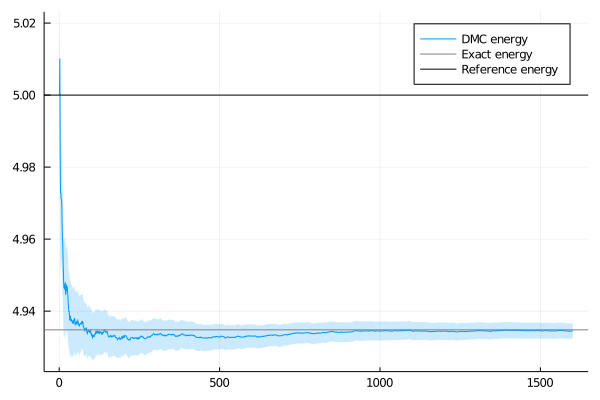

In [2]:
exact = pi^2 / 2

plot(energies, ribbon=(errors, errors), fillalpha=0.2, label="DMC energy")
hline!([exact], color="grey", labels="Exact energy")
hline!([reference_energy], color="black", labels="Reference energy")